In [1]:
import numpy as np
from strid.spatial import Node, LineElement, Mesh, LinearConstraint, SpatialModel
import matplotlib.pyplot as plt

# Spatial modelling of system for visualization of mode shapes - Shear Frame 

Visualization of mode shapes obtained in system identification is essential in modal analysis. This notebook shows how the `spatial` module of `strid` can be used to visualize a higher order model of a spatial system by converting a mode shape vector to the displacement vectors for the spatial model.

In this example, we consider a 2D shear frame with 9 floors, where each floor has height of 3.0m, and width of 5.0m.

We start by building a mesh of the shear frame with `Node`, `LineElement` and finally `Mesh` objects from the `strid.spatial` module.

Let us first define the mesh for the leftmost column:

In [2]:
n_floors = 9
height_floors = 3.0
width_floors = 5.0

nodes = [Node((0, 0, i*height_floors)) for i in range(n_floors+1)]
elements = [LineElement(nodes[i], nodes[i+1]) for i in range(n_floors)]

mesh_left_column = Mesh(nodes=nodes, elements=elements)

let us create a function to plot the meshes we create and plot the mesh of the left column:

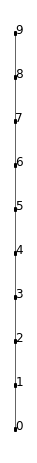

In [3]:
def plot_mesh(X, topology, ax=None, plot_nodes=True, plot_nodenums=True, color='k'):
    """Plot a mesh in the xz plane.
    
    This function takes in the geometry X and 
    the topology of a mesh and plots it in the xz plane.
    
    Arguments
    ---------
    X : 2darray
        Geometry of mesh, shape (nx3) for a mesh with `n` nodes.
        Row `i` defines the coordinate of node `i` in the mesh.
    topology : [[str, [int, int ...]]]
        Topology of mesh, shape (mx2) where m is the number of elements. 
        Each row in the list defines an element type and the connectivity
        of all elements of that type. The connectivity is given as a list 
        of node indices (refering to X) that defines the geometry 
        of the element and the connectivity of the mesh. 
    ax : Optional[matplotlib.Axes]
        Axes to plot the mesh onto.
    plot_nodes : Optional[bool]
        Plot nodes or not.
    plot_nodenums : Optional[bool]
        Plot the nodenumbers or not.
    color : Optional[str or tuple]
        Matplotlib color code for coloring the cells.
    """
    if ax is None:
        fig, ax = plt.subplots(dpi=144)
        
    # Plot nodes and nodenumbers
    if plot_nodes:
        for i, Xi in enumerate(X):
            ax.plot(Xi[0], Xi[2], 'k.', ms=3)
            if plot_nodenums:
                ax.text(Xi[0], Xi[2], f"{i}", fontsize=6)
        
    # Plot cells
    for cell_type, connectivity in topology:
        if not cell_type == "line":
            raise ValueError(
                "This function only plots LineElements, implement plotting for other elements yourself.")
        for node_ixs in connectivity:
            Xc = X[node_ixs]
            x, y = Xc[:, 0], Xc[:, 2]
            ax.plot(x, y, lw=.3, color=color)

    ax.set_aspect('equal')
    ax.axis('off')

plot_mesh(mesh_left_column.X0, mesh_left_column.topology)

then we create the mesh for the rightmost column by copying the left column and translating it to the correct place (5.0m in x-direction).

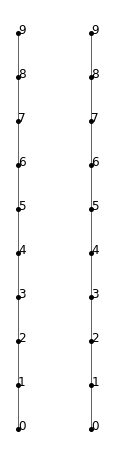

In [4]:
mesh_right_column = mesh_left_column.copy()
mesh_right_column.translate((width_floors, 0., 0.))

fig, ax = plt.subplots(dpi=144)
for mesh in [mesh_left_column, mesh_right_column]:
    plot_mesh(mesh.X0,  mesh.topology, ax=ax)


and finally we create the mesh for the shear frame by using the meshes from the two columns as submeshes and connecting them at the floor with line elements.

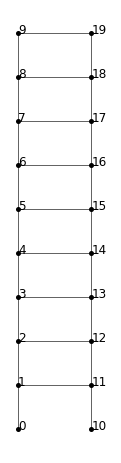

In [5]:
floor_elements = [LineElement(n1, n2) 
               for n1, n2 in 
               zip(mesh_left_column.nodes[1:], mesh_right_column.nodes[1:])]
mesh_sf = Mesh(elements=floor_elements, meshes=[mesh_left_column, mesh_right_column])

plot_mesh(mesh_sf.X0, mesh_sf.topology)

Note that the nodenumbers for the rightmost column has changed from 0-9 to 10-19 in the new mesh `mesh_sf` in comparison to the submesh `mesh_right_column`. In strid, the node numbers are determined by the mesh and is not a property of the node.

---

Let us assume that we have accelerometers installed at each floor, in the horizontal direction (x-direction) by the left column (x=0.0), i.e. at DOF 0 of nodes 1 to 9, see figure below:

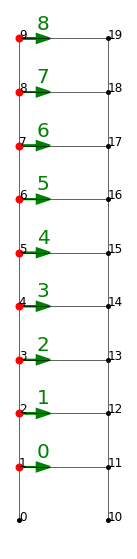

In [6]:
sensors = [mesh_sf.nodes[i].dofs[0] for i in range(1, 10)]

fig, ax = plt.subplots(dpi=144)
plot_mesh(mesh_sf.X0, mesh_sf.topology, ax=ax)
# plotting sensors
for i, sensor in enumerate(sensors):
    node = mesh_sf.find_node_by_dof(sensor)
    X = node.coordinate
    ax.plot(X[0], X[2], 'r.')
    ax.arrow(X[0], X[2], 1., 0., color='g', head_width=.5)
    ax.text(X[0]+1, X[2]+.5, f"{i}", color='g')
    
ax.set_aspect('equal')
ax.axis('off')
fig.tight_layout()

Given this sensor layout, our system identification will give us a mode vector which corresponds to the deformation at nodes 1 to 9 in the x-direction. The other dofs of this model must either be constrained to a predefined value or in terms of the sensor dofs.

Let us start with the out of plane dofs. This is a 2D shear frame, and all deformations out of plane (y-direction) are assumed to be zero, i.e. DOF 1 (y-direction) of nodes [0,19] has a predefined value of zero. In strid, predefined values are imposed with linear constraint equations.

In [7]:
constraints_y = []
for node in mesh_sf.nodes: # all nodes of mesh
    constraint = LinearConstraint([node.dofs[1], ], [1.,], constant=0.)
    constraints_y.append(constraint)

Next, consider the boundary conditions of the mesh. Node 0 and 10 are fixed, i.e. all dofs of these nodes are constrained to 0. Note that we already constrained dof 1 (y-direction) in the previous step, and we only have constrain dof 0 (x-direction) and 2 (z-direction) at these nodes.

In [8]:
constraints_bc = []
for nodenum in [0, 10]:
    for dofnum in [0, 2]:
        dof = mesh_sf.nodes[nodenum].dofs[dofnum]
        constraint = LinearConstraint([dof, ], [1.], constant=0.0)
        constraints_bc.append(constraint)

With our understanding of mechanical structures and elements, we know that in general, the axial deformation of a beam is negligible compared to transversal deformation. 

Considering the horizontal direction first (x-direction), this means that the free dofs in the x-direction at the right column has the same deformation as the corresponding sensor dofs at the left column. That is, the horizontal deformation of node 11 is the same as the horizontal deformation of node 1, assuming that the axial deformation of the floor between node 1 and 11 is negligible to the horizontal deformation due to bending of the columns. 

Mathematically, this can be described as

$u_{11} = u_{1}$

or equivalently 

$u_{1} - u_{11} = 0$

which again is a linear constraint equation and can be imposed in strid for the nodes at the left and right columns as

In [9]:
constraints_x = []
for nodenum_left, nodenum_right in zip(range(1, 10), range(11, 20)):
    dofx_left = mesh_sf.nodes[nodenum_left].dofs[0]
    dofx_right = mesh_sf.nodes[nodenum_right].dofs[0]
    constraint = LinearConstraint([dofx_left, dofx_right], [1., -1.], constant=0.)
    constraints_x.append(constraint)

Finally, the dofs in the vertical direction (z-direction) must be considered. Again, axial deformation is assumed to be negligible to the transversal deformation, and since nodes 0 and 10 are fixed (boundary condition), it follows that all other dofs in the vertical direction are also zero.

In [10]:
constraints_z = []
for nodenum in range(20):
    dof = mesh_sf.nodes[nodenum].dofs[2]
    constraint = LinearConstraint([dof,], [1.], constant=0.0)
    constraints_z.append(constraint)

We can now create a model of the system and check if the model is consistent, i.e. that we 
have constrained the model properly.

In [11]:
constraints = constraints_x + constraints_y + constraints_z + constraints_bc
model = SpatialModel(mesh_sf, sensors, constraints)
model.check_consistency()

StridError: Constraint error(s), non-sensor dofs must be present in one and only one constraint equation.
	Node 0, DOF 2 (z-dir) present in more than one constraint.
	Node 10, DOF 2 (z-dir) present in more than one constraint.

Ups, there is an error. The error message tells us that dof 2 (z-direction) in node 0 and 10 are involved in more than one constraint equation, i.e. there are two overconstraints. Looking back, we realize that dof 2 of node 0 and 10 has been constrained in both our handling of boundary conditions and of dofs in the z-direction.

To fix this, we rewrite the constraints in the z-direction to exclude node 0 and 10, and then redo the consistency check

In [12]:
constraints_z = []
for nodenum in range(20):
    if (nodenum == 0) or (nodenum == 10):
        continue
    dof = mesh_sf.nodes[nodenum].dofs[2]
    constraint = LinearConstraint([dof,], [1.], constant=0.0)
    constraints_z.append(constraint)
    
constraints = constraints_x + constraints_y + constraints_z + constraints_bc
model = SpatialModel(mesh_sf, sensors, constraints)
model.check_consistency()

and now the model passes the consistency check.

Note that the consistency checking can (should) be used actively when establishing the constraints of a model. The check also informs if the model is underconstrained, see below where the boundary conditions are omitted

In [13]:
constraints_wo_bc = constraints_x + constraints_y + constraints_z # + constraints_bc
model_wo_bc = SpatialModel(mesh_sf, sensors, constraints_wo_bc)
model_wo_bc.check_consistency()

StridError: Constraint error(s), non-sensor dofs must be present in one and only one constraint equation.
	Node 0, DOF 0 (x-dir) is not present in any constraint.
	Node 0, DOF 2 (z-dir) is not present in any constraint.
	Node 10, DOF 0 (x-dir) is not present in any constraint.
	Node 10, DOF 2 (z-dir) is not present in any constraint.

Now that we have a consistent model, we can convert a mode shape vector to a deformation array for the mesh. For a shear frame with constant stiffness of columns over the entire height and same mass of all floors, the analytical mode shape is given by $u$ below.

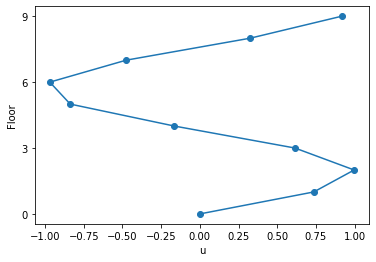

In [14]:
def mode_shape_sf(mode_number, n_floors):
    i = np.arange(0, n_floors+1)
    u =  np.sin(i*np.pi*(2*mode_number-1)/(2*n_floors+1))
    return i, u

mode_number = 3
i, u = mode_shape_sf(mode_number, n_floors)
plt.plot(u, i, '-o')
plt.xlabel("u")
plt.ylabel("Floor")
plt.yticks(range(0, 12, 3))

u = u[1:] # Leave out the zeroth node.

We now use this mode shape to calculate the deformed geometry for all nodes of the mesh with the spatial model that we have established.

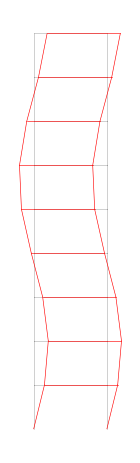

In [15]:
X0 = model.X0  # Undeformed geometry
X = model.X(u) # Deformed geometry (mode shape)

topology = model.topology

fig, ax = plt.subplots(dpi=144)
colors = ['r', (0., 0., 0., .3)]
for Xi in [X0, X]:
    plot_mesh(Xi, topology, ax=ax, plot_nodes=False, color=colors.pop())
        


In this example, we have used matplotlib to visualize the mesh in xz plane from the geometry and topology established by the spatial modelling. Matplotlib may be sufficient for many visualization tasks, especially for 2D structures, and perhaps also for 3D structures when an appropriate projection is used (see e.g. `strid.spatial.isometric_projection`).

However, for general 3D structures, it is necessary to look outside of 2D plotting in `matplotlib`. Some suggestions  (at the time of writing this example) for 3D plotting in python are the packages `pyvista` and `mayavi`.

Another option is to go outside of python.

[ParaView](https://www.paraview.org/) is an open-source, multi-platform data analysis and visualization application well suited for the purpose of visualizing and animating meshes. 

Below, we export the mesh and the mode shape to a `.vtu` file with the `meshio` package. The mesh and modeshapes can then be imported into ParaView and further analyzed therein. (See animation from ParaView of mode shape 3 of the shear frame at the bottom of this example). 

In [16]:
import meshio

point_data ={}
for mode_num in range(1, 10):
    floor, u = mode_shape_sf(mode_num, n_floors)
    point_data[f"Mode {mode_num}"] = model.U(u[1:])
    

mesh = meshio.Mesh(model.X0, model.topology, point_data=point_data)
mesh.write("shear-frame.vtu")

![mode3](mode3sf.gif)